In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import os 
import sys 
import re
from tqdm import tqdm
from joblib import Parallel, delayed

/home/daiwei/miniconda3/envs/rlhf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
grid_search_fileNames = os.listdir('./save_samplesize/')
grid_search_filePaths = [os.path.join('./save_samplesize/',i) for i in grid_search_fileNames]

In [3]:
train_stats_samples_all = []

def tmp_fun(filePath):
    res = torch.load(filePath)
    return({**res['args'], 'test_accu_record': res['train_stats']['test_accu_record']})

train_stats_samples_all = Parallel(n_jobs=32)(delayed(tmp_fun)(i) for i in tqdm(grid_search_filePaths))

100%|██████████| 27/27 [00:00<00:00, 1867.61it/s]


In [23]:
samplesize = []
final_test_accu = []
for i in train_stats_samples_all:
    samplesize.append(i['num_pairs_per_user'])
    final_test_accu.append(i['test_accu_record'][-1])

In [24]:
samplesize, final_test_accu = list(zip(*sorted(zip(samplesize,final_test_accu))))

Text(0.5, 1.0, 'Color Preference Prediction Accuracy')

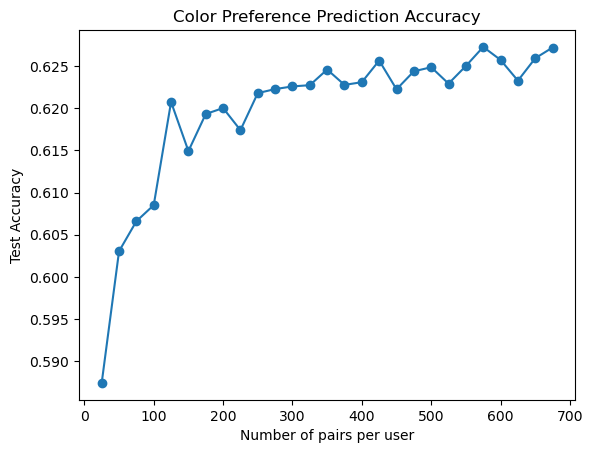

In [25]:
fig,ax = plt.subplots()
ax.plot(samplesize,final_test_accu, '-o')
ax.set_xlabel('Number of pairs per user')
ax.set_ylabel('Test Accuracy')
ax.set_title('Color Preference Prediction Accuracy')